# TF Serving

## Environment

- python 3 에서 동작하므로 python 3 세팅을 확인합니다.

In [1]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

- Colab 에서 필요한 환경 세팅을 해줍니다.

In [2]:
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

Installing dependencies for Colab environment
     |████████████████████████████████| 2.4 MB 6.1 MB/s 


## Import

In [3]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

- tensorflow 버전을 확인합니다. 2.x

In [4]:
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.7.0


## Create Model

### Import Fashion MNIST dataset
Keras 데이터셋에 있는 Fashion_mnist 를 사용할 것입니다.

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4431872/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Make model
학습 모델을 만들어 줍니다.

In [6]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


### Train Model

모델을 학습시킵니다.

In [7]:
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5297 - sparse_categorical_accuracy: 0.8164
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3702 - sparse_categorical_accuracy: 0.8685
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3375 - sparse_categorical_accuracy: 0.8801
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3188 - sparse_categorical_accuracy: 0.8864
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3434 - sparse_categorical_accuracy: 0.8727

Test accuracy: 0.8726999759674072


## Save Model
TF Serveing 에 로드하기 위해서는 SaveModel 형식으로 저장을 하는 것이 필요합니다.<BR>
따라서, 아래와 같이 저장을 해주어야 합니다.

In [8]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1



INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
total 92
drwxr-xr-x 2 root root  4096 Jan  3 13:31 assets
-rw-r--r-- 1 root root  8228 Jan  3 13:31 keras_metadata.pb
-rw-r--r-- 1 root root 71243 Jan  3 13:31 saved_model.pb
drwxr-xr-x 2 root root  4096 Jan  3 13:31 variables


- 왼쪽에 폴더메뉴에서 아래의 위치로 가면 저장된 것을 확인 가능합니다.

In [9]:
print(export_path)

/tmp/1


### Examine saved model
저장된 모델에서 모델 및 호출할 수 있는 메서드를 봅니다.<br>
(Tensoflow 가이드에서 SavedModel CLI 에 대한 가이드를 참고하세요.)

In [10]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          Conv1_input:

## Serve Model

### URI Package
Tensorflow Serving 배포 URI 패키지소스를 추가합니다.<br> Colab 은 Debian 환경에서 실행되기 때문에 Aptitude 를 사용하여 Tensorflow Serving 을 설치할 준비를 합니다.

- 주의 : Google Colab 이 아닌 로컬에서 아래의 셀을 실행하면 루트 액세스 권한으로 패키지가 설치 되니 주의해서 진행하세요.

In [11]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [12]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  12012      0 --:--:-- --:--:-- --:--:-- 11963
OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/

### Install Tensorflow Serving

In [13]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 100 not upgraded.
Need to get 335 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.7.0 [335 MB]
Fetched 335 MB in 5s (71.3 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.7.0_all.deb ...
Unpacking tensorflow-model-server (2.7.0) ...
Setting up tensorflow-model-server (2.7.0) ...


### Start TensorFlow Serving


In [14]:
os.environ["MODEL_DIR"] = MODEL_DIR

- rest_api_port : REST 요청에 사용할 포트입니다.
- model_name : REST 요청의 URL 에서 이것을 사용합니다.
- model_base_path : 모델을 저장한 디렉토리의 경로입니다.

In [15]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 0 in a separate thread.


- log 로 잘 실행되는지 확인

In [16]:
!cat server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


* 로그 확인시 HTTP 서버가 작동이 안된다는 메세지가 나오면 이미 실행중인 tensorflow_model_server 가 있을 수 있습니다.<BR> 그런 경우, 아래의 코드로 찾아서 kill 명령으로 서버를 꺼줘야 합니다.

In [17]:
# !ps -ef

### Make a request

- 데이터셋에서 랜덤하게 데이터를 가져옵니다.

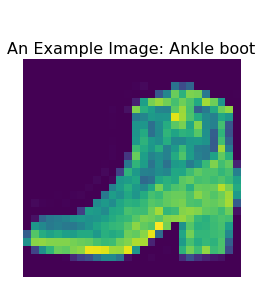

In [18]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

-  데이터를 Json 형태로 만들어줍니다.

In [19]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[rando:rando+3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... [0.2823529411764706], [0.0], [0.0], [0.0], [0.0]]]]}


- 특정버전을 지정도 가능하지만 현재는 하나만 있어서 1 을 선택합니다.

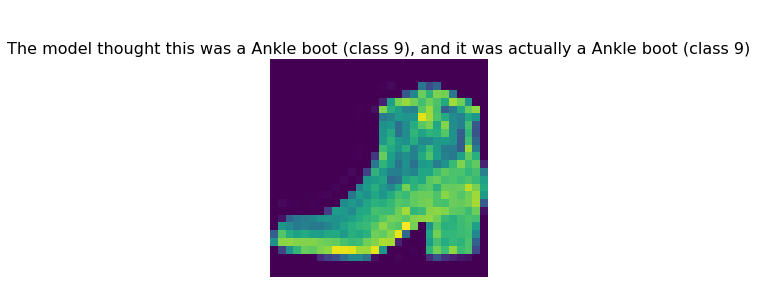

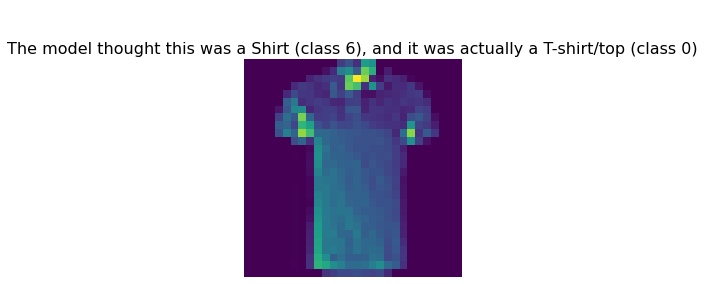

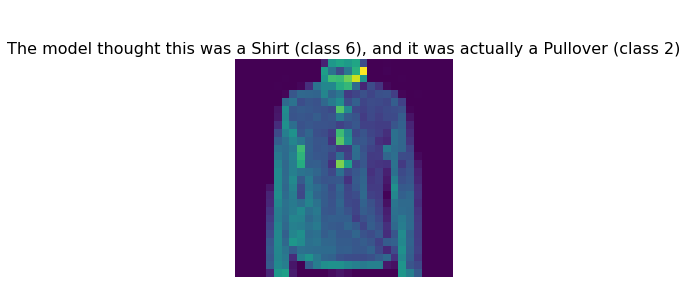

In [20]:
# docs_infra: no_execute
!pip install -q requests

import requests
# docs_infra: no_execute
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(rando+i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[rando+i]], test_labels[rando+i]))